In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from IPython import display
from sklearn.model_selection import train_test_split
%matplotlib inline

import pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
data1 = unpickle("data/cifar-10-batches-py/data_batch_1")
data2 = unpickle("data/cifar-10-batches-py/data_batch_2")
data3 = unpickle("data/cifar-10-batches-py/data_batch_3")
data4 = unpickle("data/cifar-10-batches-py/data_batch_4")
data5 = unpickle("data/cifar-10-batches-py/data_batch_5")
label_data = unpickle('data/cifar-10-batches-py/batches.meta')[b'label_names']

labels1 = data1[b'labels']
data1 = data1[b'data'] * 1.0
labels2 = data2[b'labels']
data2 = data2[b'data'] * 1.0
labels3 = data3[b'labels']
data3 = data3[b'data'] * 1.0
labels4 = data4[b'labels']
data4 = data4[b'data']  * 1.0
labels5 = data5[b'labels']
data5 = data5[b'data']  * 1.0

# Combine the remaining four arrays to use as training data
X_tr = np.concatenate([data1, data2, data3, data4, data5], axis=0)
X_tr = np.dstack((X_tr[:, :1024], X_tr[:, 1024:2048], X_tr[:, 2048:])) / 255.0
X_tr = X_tr.reshape(-1, 32, 32, 3)

y_tr = np.concatenate([labels1, labels2, labels3, labels4, labels5], axis=0)

# set number of classes
num_classes = len(label_data)

print("X_tr", X_tr.shape)
print("y_tr", y_tr.shape)

X_tr (50000, 32, 32, 3)
y_tr (50000,)


In [3]:
# import the test data
test_data = unpickle("data/cifar-10-batches-py/test_batch")

X_test = test_data[b'data']
X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:])) / 255.0
X_test = X_test.reshape(-1, 32, 32, 3)
y_test = np.asarray(test_data[b'labels'])

# split into test and validation
X_te, X_cv, y_te, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

print("X_te", X_te.shape)
print("X_cv", X_cv.shape)
print("y_te", y_te.shape)
print("y_cv", y_cv.shape)

X_te (5000, 32, 32, 3)
X_cv (5000, 32, 32, 3)
y_te (5000,)
y_cv (5000,)


In [4]:
IMAGE_SIZE = 24

# Batch generator
def get_batches(X, y, batch_size, crop=False, distort=True):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    i, h, w, c = X.shape
    
    # Enumerate indexes by steps of batch_size
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i:i+batch_size]
        X_return = X[batch_idx]
        
        # optional random crop of images
        if crop:
            woff = (w - 24) // 2
            hoff = (h - 24) // 2
            startw = np.random.randint(low=0,high=woff)
            starth = np.random.randint(low=0,high=hoff)
            X_return = X_return[:,startw:startw+24,starth:starth+24,:]
       
        # do random flipping of images
        coin = np.random.binomial(1, 0.5, size=None)
        if coin and distort:
            X_return = X_return[...,::-1,:]
        
        yield X_return, y[batch_idx]

## Create the Model

In [5]:
## MODEL 1
# Create new graph
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = True
crop = False
model_name = "model_1"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.002,               # start at 0.002
                                               global_step, 
                                               2000,                # 2000 steps
                                               0.9,                 # 0.90 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    # Convolutional layer 1     
    with tf.name_scope('conv1') as scope:
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(5, 5),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv1'                 
        )

         # batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # relu activation
        conv1_bn_relu = tf.nn.relu(bn1, name='relu1')
    
    # Max pooling layer 1
    with tf.name_scope('pool1') as scope:
        pool1 = tf.layers.max_pooling2d(
            conv1_bn_relu,               # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # dropout at 0.125
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
       
    # Convolutional layer 2
    with tf.name_scope('conv2') as scope:
        conv2 = tf.layers.conv2d(
            pool1,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(5, 5),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='conv2'           
        )

        # batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        # relu activation
        conv2_bn_relu = tf.nn.relu(bn2, name='relu2')
    
    # Max pooling layer 2 (3x3, stride: 2)
    with tf.name_scope('pool2') as scope:
        pool2 = tf.layers.max_pooling2d(
            conv2_bn_relu,               # input
            pool_size=(3, 3),            # pool size 3x3
            strides=(2, 2),              # stride 2
            padding='SAME',
            name='pool2'
        )

        # dropout at 0.125
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    # Flatten output
    with tf.name_scope('flatten') as scope:
        flat_output = tf.contrib.layers.flatten(pool2)

        # dropout at 25%
        flat_output = tf.layers.dropout(flat_output, rate=0.25, seed=1, training=training)
    
    # Fully connected layer
    with tf.name_scope('fc1') as scope:
        fc1 = tf.layers.dense(
            flat_output,                 # input
            384,                         # 384 hidden units
            activation=None,       
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='fc1'

        )

        # batch normalization
        bn3 = tf.layers.batch_normalization(
            fc1,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        # relu activation
        fc1_bn_relu = tf.nn.relu(bn3, name='relu3')

        # dropout at 30%
        # fc1 = tf.layers.dropout(fc1, rate=0.30, seed=1, training=training)
    
    # Fully connected layer 2
    with tf.name_scope('fc2') as scope:
        fc2 = tf.layers.dense(
            fc1_bn_relu,                 # input
            192,                         # 192 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.1),
            name='fc2'
        )

        # dropout at 25%
        fc2 = tf.layers.dropout(fc2, rate=0.25, seed=1, training=training)
    
    
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                 # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='logits'
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    with tf.variable_scope('conv2', reuse=True):
        conv_kernels2 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries
    merged = tf.summary.merge_all()
    
    # add this so that the batch norm gets 
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [5]:
## Model 9
# Create new graph
graph = tf.Graph()
model_name = "model_9"
init = True
crop = False

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.003,               # start at 0.003
                                               global_step, 
                                               3200,                # 3200 steps
                                               0.9,                 # 0.9 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv1'                  # Add name
        )

         # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        relu1 = tf.nn.relu(bn1, name='relu1')
    
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            relu1,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        # apply relu
        relu2 = tf.nn.relu(bn2, name='relu2')
   
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            relu2,                       # Input
            pool_size=(2, 2),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool1,                       # Input
            filters=96,                  # 96 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv3'                 # Add name
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        # apply relu
        relu3 = tf.nn.relu(bn3, name='relu3')

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            relu3,                       # Input
            filters=96,                  # 96 filters
            kernel_size=(3, 3),          # Kernel size: 3x3
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv4'                 # Add name
        )

        # try batch normalization
        norm4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        # apply relu
        relu4 = tf.nn.relu(norm4, name='relu4')
    
    with tf.name_scope('pool2') as scope:
        pool2 = tf.layers.max_pooling2d(
            relu4,                       # input
            pool_size=(2, 2),            # pool size 2x2
            strides=(2, 2),              # stride 2
            padding='SAME',
            name='pool2'
        )

        # try dropout here
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool2)

        # dropout at 12.50%
        #flat_output = tf.layers.dropout(flat_output, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            512,                         # 512 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc1'
        )
        
        # dropout at 12.5%
        fc1 = tf.layers.dropout(fc1, rate=0.1250, seed=1, training=training)

    with tf.name_scope('fc2') as scope:
        # Fully connected layer
        fc2 = tf.layers.dense(
            fc1,                         # input
            256,                         # 256 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc2'
        )
        
        # dropout at 12.5%
        fc2 = tf.layers.dropout(fc2, rate=0.1250, seed=1, training=training)        
        
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='logits'
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [16]:
## Model 8
# Create new graph
graph = tf.Graph()
model_name = "model_8"
init = False

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.003,               # start at 0.003
                                               global_step, 
                                               3200,                # 2400 steps
                                               0.9,                 # 0.95 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 2
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv1'                  # Add name
        )

         # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        relu1 = tf.nn.relu(bn1, name='relu1')
    
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            relu1,                           # Input data
            filters=32,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 2
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        # apply relu
        relu2 = tf.nn.relu(bn2, name='relu2')
   
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            relu2,                       # Input
            pool_size=(2, 2),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool1,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv3'                 # Add name
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        # apply relu
        relu3 = tf.nn.relu(bn3, name='relu3')

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            relu3,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv4'                 # Add name
        )

        # try batch normalization
        norm4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        # apply relu
        relu4 = tf.nn.relu(norm4, name='relu4')
    
    with tf.name_scope('pool2') as scope:
         # Max pooling layer 2 (2x2, stride: 2) - TUNED
        pool2 = tf.layers.max_pooling2d(
            relu4,                       # input
            pool_size=(2, 2),            # pool size 2x2
            strides=(2, 2),              # stride 2
            padding='SAME',
            name='pool2'
        )

        # try dropout here
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool2)

        # dropout at 50%
        # flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=1, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            512,                         # 512 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc1'
        )
        
        # dropout at 12.5%
        fc1 = tf.layers.dropout(fc1, rate=0.1250, seed=1, training=training)

    with tf.name_scope('fc2') as scope:
        # Fully connected layer
        fc2 = tf.layers.dense(
            fc1,                         # input
            256,                         # 256 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc2'
        )
        
        # dropout at 12.5%
        fc2 = tf.layers.dropout(fc2, rate=0.1250, seed=1, training=training)        
        
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='logits'
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [8]:
## Model 11
# Create new graph
graph = tf.Graph()
model_name = "model_11"
init = False

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.003,               # start at 0.003
                                               global_step, 
                                               3200,                # 3200 steps
                                               0.85,                 # 0.9 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(5, 5),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv1'                  # Add name
        )

         # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        relu1 = tf.nn.relu(bn1, name='relu1')
    
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            relu1,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(5, 5),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        # apply relu
        relu2 = tf.nn.relu(bn2, name='relu2')
   
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            relu2,                       # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool1,                       # Input
            filters=96,                  # 96 filters
            kernel_size=(4, 4),          # Kernel size: 4x4
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv3'                 # Add name
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        # apply relu
        relu3 = tf.nn.relu(bn3, name='relu3')

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            relu3,                       # Input
            filters=96,                  # 96 filters
            kernel_size=(4, 4),          # Kernel size: 4x4
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv4'                 # Add name
        )

        # try batch normalization
        norm4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        # apply relu
        relu4 = tf.nn.relu(norm4, name='relu4')
    
    with tf.name_scope('pool2') as scope:
        pool2 = tf.layers.max_pooling2d(
            relu4,                       # input
            pool_size=(3, 3),            # pool size 3x3
            strides=(2, 2),              # stride 2
            padding='SAME',
            name='pool2'
        )

        # try dropout here
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool2)

        # dropout at 12.50%
        flat_output = tf.layers.dropout(flat_output, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            512,                         # 512 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc1'
        )
        
        # dropout at 12.5%
        fc1 = tf.layers.dropout(fc1, rate=0.1250, seed=1, training=training)

    with tf.name_scope('fc2') as scope:
        # Fully connected layer
        fc2 = tf.layers.dense(
            fc1,                         # input
            256,                         # 256 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc2'
        )
        
        # dropout at 12.5%
        fc2 = tf.layers.dropout(fc2, rate=0.1250, seed=1, training=training)        
        
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='logits'
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [6]:
## CONFIGURE OPTIONS
init = True                   # whether to initialize the model or use a saved version
crop = False
# Placeholders for metrics
if init:
    valid_acc_values = []
    valid_cost_values = []
    train_acc_values = []
    train_cost_values = []

# config
epochs = 50                    # how many epochs
print_every = 3                # how often to print metrics
checkpoint_every = 1           # how often to save model in epochs
use_gpu = True                 # whether or not to use the GPU
print_metrics = False          # whether to print or plot metrics, if False a plot will be created and updated every epoch
batch_size = 64
meta_data_every = 5

if use_gpu:
    config = tf.ConfigProto()
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.7
else:
    config = tf.ConfigProto(device_count = {'GPU': 0})

In [8]:
epochs = 36

Saving checkpoint


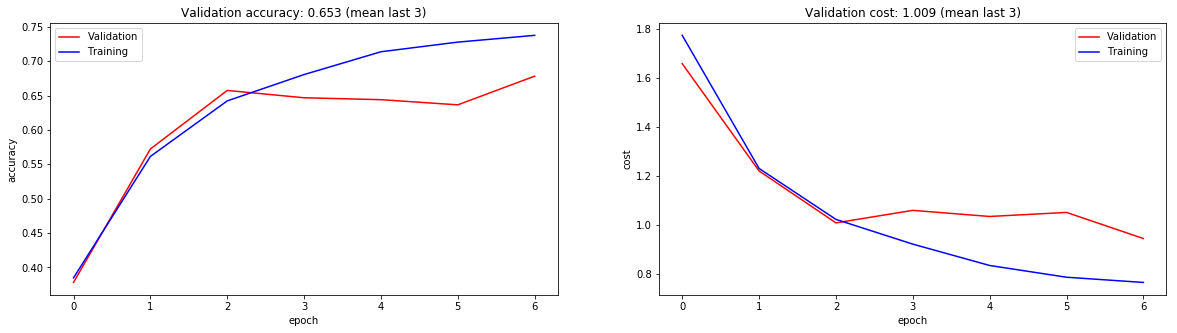

In [ ]:
# reinitialize the step counter if neccessary, this is used for tensorboard logging
if init:
    step_counter = 0

# train the model
with tf.Session(graph=graph, config=config) as sess:
    train_writer = tf.summary.FileWriter('./logs/tr_' + model_name, sess.graph)
    test_writer = tf.summary.FileWriter('./logs/te_' + model_name)
    
    if not print_metrics:
        # create a plot to be updated as model is trained
        f, ax = plt.subplots(1,2,figsize=(20,5))
    
    # create the saver
    saver = tf.train.Saver()
    
    # If the model is new initialize variables, else restore the session
    if init:
        sess.run(tf.global_variables_initializer())
    else:
        saver.restore(sess, './model/cifar_'+model_name+'.ckpt')

    # Set seed
    np.random.seed(0)
    
    print("Training", model_name, "...")
    
    # Train several epochs
    for epoch in range(epochs):
        # Accuracy values (train) after each batch
        batch_acc = []
        batch_cost = []
        # only log run metadata once per epoch
        write_meta_data = True
            
        for X_batch, y_batch in get_batches(X_tr, y_tr, batch_size, crop=crop, distort=True):
            if write_meta_data:
                # create the metadata
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            
                # Run training and evaluate accuracy
                _, _, summary, acc_value, cost_value, step = sess.run([train_op, extra_update_ops, merged, accuracy, mean_ce, global_step], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    training: True
                },
                options=run_options,
                run_metadata=run_metadata)

                # Save accuracy (current batch)
                batch_acc.append(acc_value)
                batch_cost.append(cost_value)

                # write the summary
                train_writer.add_run_metadata(run_metadata, 'step %d' % step)
                train_writer.add_summary(summary, step)
                write_meta_data = False
                
            else:
                # Run training without meta data
                _, _, summary, acc_value, cost_value, step = sess.run([train_op, extra_update_ops, merged, accuracy, mean_ce, global_step], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    training: True
                })

                # Save accuracy (current batch)
                batch_acc.append(acc_value)
                batch_cost.append(cost_value)

                # write the summary
                train_writer.add_summary(summary, step)

        # save checkpoint every nth epoch
        if(epoch % checkpoint_every == 0):
            print("Saving checkpoint")
            # save the model
            save_path = saver.save(sess, './model/cifar_'+model_name+'.ckpt')
    
            # Now that model is saved set init to false so we reload it
            init = False
        
        # init batch arrays
        batch_cv_acc = []
        batch_cv_cost = []
        
        # Evaluate validation accuracy with batches so as to not crash the GPU
        for X_batch, y_batch in get_batches(X_cv, y_cv, batch_size, crop=crop, distort=False):
            summary, valid_acc, valid_cost = sess.run([merged, accuracy, mean_ce], feed_dict={
                X: X_batch,
                y: y_batch,
                training: False
            })

            batch_cv_acc.append(valid_acc)
            batch_cv_cost.append(valid_cost)

        # Write average of validation data to summary logs
        summary = tf.Summary(value=[tf.Summary.Value(tag="accuracy", simple_value=np.mean(batch_cv_acc)),tf.Summary.Value(tag="cross_entropy", simple_value=np.mean(batch_cv_cost)),])
        test_writer.add_summary(summary, step)
        step += 1
            
        # take the mean of the values to add to the metrics
        valid_acc_values.append(np.mean(batch_cv_acc))
        valid_cost_values.append(np.mean(batch_cv_cost))
        train_acc_values.append(np.mean(batch_acc))
        train_cost_values.append(np.mean(batch_cost))
    
        if print_metrics:
            # Print progress every nth epoch to keep output to reasonable amount
            if(epoch % print_every == 0):
                print('Epoch {:02d} - step {} - cv acc: {:.3f} - train acc: {:.3f} (mean) - cv cost: {:.3f} - lr: {:.5f}'.format(
                    epoch, step, valid_acc, np.mean(batch_acc), valid_cost, lr
                ))
        else:
            # update the plot
            ax[0].cla()
            ax[0].plot(valid_acc_values, color="red", label="Validation")
            ax[0].plot(train_acc_values, color="blue", label="Training")
            ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))

            ax[0].set_xlabel('epoch')
            ax[0].set_ylabel('accuracy')
            ax[1].cla()
            ax[1].plot(valid_cost_values, color="red", label="Validation")
            ax[1].plot(train_cost_values, color="blue", label="Training")
            ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
            ax[1].set_xlabel('epoch')
            ax[1].set_ylabel('cost')
            ax[1].legend()
            ax[0].legend()

            display.display(plt.gcf())
            display.clear_output(wait=True)
            
    # print results of last epoch
    print('Epoch {} - cv acc: {:.3f} - train acc: {:.3f} (mean) - cv cost: {:.3f}'.format(
                epochs, valid_acc, np.mean(batch_acc), valid_cost
            ))
    
    # save the session
    save_path = saver.save(sess, './model/cifar_'+model_name+'.ckpt')
    
    # init the test data array
    test_acc_values = []
    
    # Check on the test data
    for X_batch, y_batch in get_batches(X_te, y_te, batch_size, crop=crop, distort=False):
        test_accuracy = sess.run(accuracy, feed_dict={
            X: X_batch,
            y: y_batch,
            training: False
        })
        test_acc_values.append(test_accuracy)
    
    # average test accuracy across batches
    test_acc = np.mean(test_acc_values)
    
# show the plot
plt.show()

# print test accuracy
print("Convolutional network accuracy (test set):",test_acc)

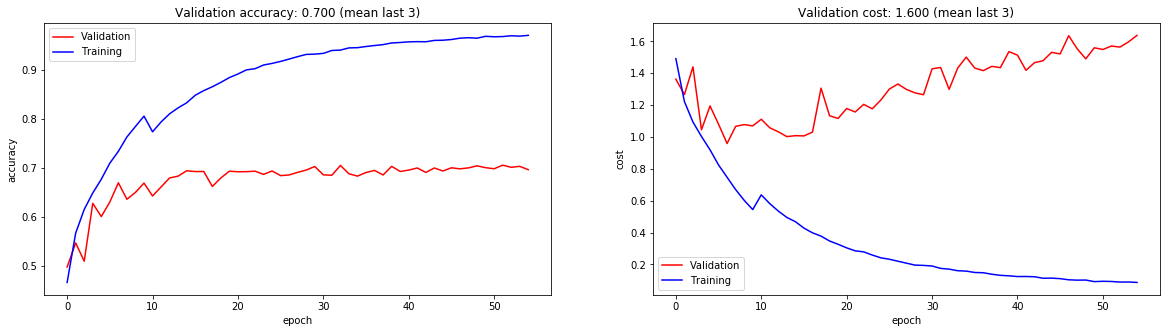

Convolutional network accuracy (test set): 0.7027294


In [12]:
## MODEL 9 - no crop
# Plot cost and accuracy and training and validation
f, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Convolutional network accuracy (test set):",test_acc)

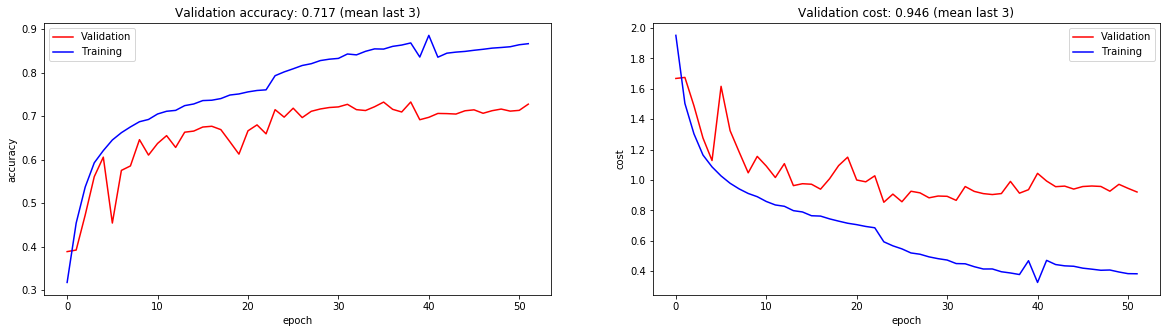

Convolutional network accuracy (test set): 0.711432


In [20]:
## MODEL 8

# Plot cost and accuracy and training and validation
f, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Convolutional network accuracy (test set):",test_acc)

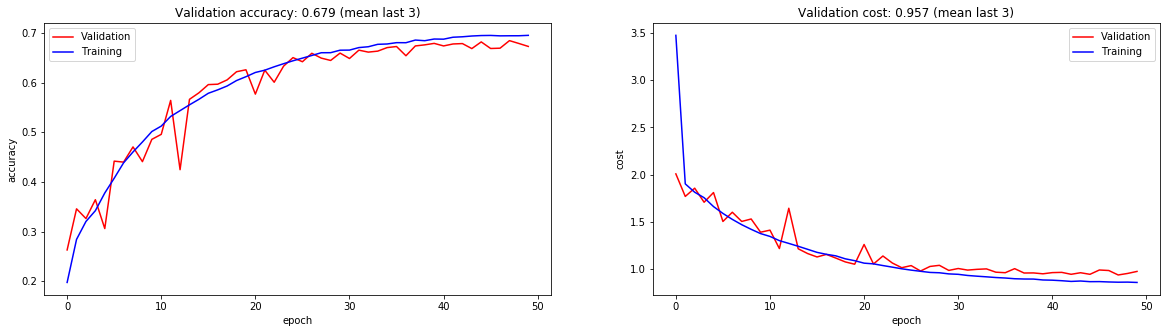

Convolutional network accuracy (test set): 0.6744462


In [9]:
## MODEL 3
# Plot cost and accuracy and training and validation
f, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Convolutional network accuracy (test set):",test_acc)

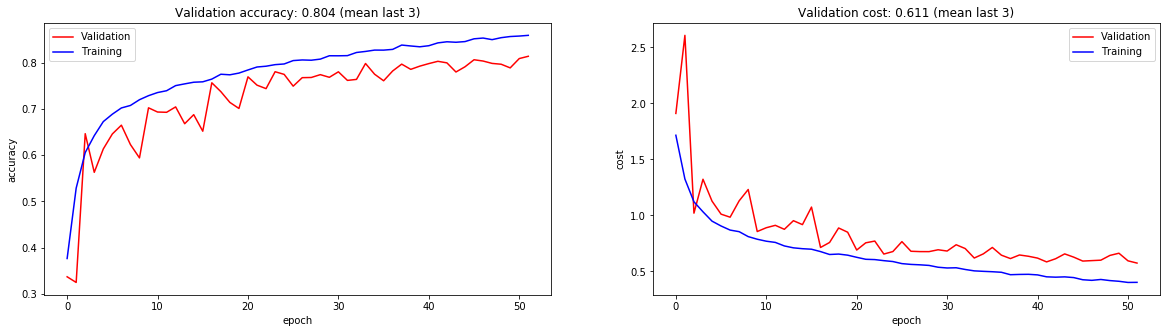

NameError: name 'test_acc' is not defined

In [13]:
## MODEL 12 - cropped
# Plot cost and accuracy and training and validation
f, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].set_title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
ax[0].legend()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation cost: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-3:])))
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('cost')
plt.legend()
plt.show()

print("Convolutional network accuracy (test set):",test_acc)

In [5]:
## Model 12
# Create new graph
graph = tf.Graph()
model_name = "model_12"
init = True
crop = True

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 24, 24, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    # Decay the learning rate - 
    learning_rate = tf.train.exponential_decay(0.003,               # start at 0.003
                                               global_step, 
                                               3200,                # 2400 steps
                                               0.85,                 # 0.95 increment
                                               staircase=True)
    
    # Small epsilon value for the BN transform
    epsilon = 1e-3
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 2
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv1'                  # Add name
        )

         # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        relu1 = tf.nn.relu(bn1, name='relu1')
    
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            relu1,                           # Input data
            filters=32,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 2
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0), # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv2'                  # Add name
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        # apply relu
        relu2 = tf.nn.relu(bn2, name='relu2')
   
    with tf.name_scope('pool1') as scope:
         # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            relu2,                       # Input
            pool_size=(2, 2),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )

        # try dropout here
        pool1 = tf.layers.dropout(pool1, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3= tf.layers.conv2d(
            pool1,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv3'                 # Add name
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        # apply relu
        relu3 = tf.nn.relu(bn3, name='relu3')

    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4= tf.layers.conv2d(
            relu3,                       # Input
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,       # ReLU
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=0),    # Small standard deviation
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.001),
            name='conv4'                 # Add name
        )

        # try batch normalization
        norm4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        # apply relu
        relu4 = tf.nn.relu(norm4, name='relu4')
    
    with tf.name_scope('pool2') as scope:
         # Max pooling layer 2 (2x2, stride: 2) - TUNED
        pool2 = tf.layers.max_pooling2d(
            relu4,                       # input
            pool_size=(2, 2),            # pool size 2x2
            strides=(2, 2),              # stride 2
            padding='SAME',
            name='pool2'
        )

        # try dropout here
        pool2 = tf.layers.dropout(pool2, rate=0.125, seed=1, training=training)
    
    with tf.name_scope('flatten') as scope:
        # Flatten output
        flat_output = tf.contrib.layers.flatten(pool2)

        # dropout at 50%
        # flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=1, training=training)
    
    with tf.name_scope('fc1') as scope:
        # Fully connected layer
        fc1 = tf.layers.dense(
            flat_output,                 # input
            512,                         # 512 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc1'
        )
        
        # dropout at 12.5%
        fc1 = tf.layers.dropout(fc1, rate=0.1250, seed=1, training=training)

    with tf.name_scope('fc2') as scope:
        # Fully connected layer
        fc2 = tf.layers.dense(
            fc1,                         # input
            256,                         # 256 hidden units
            activation=tf.nn.relu,       # ReLU
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=0.0001),
            name='fc2'
        )
        
        # dropout at 12.5%
        fc2 = tf.layers.dropout(fc2, rate=0.1250, seed=1, training=training)        
        
    # Output layer
    logits = tf.layers.dense(
        fc2,                         # input
        num_classes,                           # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='logits'
    )
    
    # Kernel weights of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    gd = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = gd.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('learning_rate', learning_rate)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()